In [22]:
from matplotlib import pyplot as plt, colors as mcolors, colormaps
import numpy as np
from scipy.spatial.distance import cosine as cos_dist


In [3]:
color = lambda cmap, vmin, vmax, v: colormaps[cmap](mcolors.Normalize(vmin=vmin, vmax=vmax)(v))


In [38]:
def spec_norm(spectrum):
    """ normalize spectrum such that all intensities sum to 1 """
    mz, i = np.array(spectrum)
    return np.array([mz, i / sum(i)])


def spec_entropy(spectrum):
    """ compute spectral entropy for single spectrum """
    mz, i = spectrum
    return -np.sum(i * np.log(i + 0.001))
    

def spec_combine(spectra, comb_mztol=0.1):
    """ combine multiple spectra into a single spectrum """
    comb_mz, comb_i = [], []
    # iterate through spectra in set
    # combine m/zs that are within tolerance of one another
    # otherwise just add the new points
    for spectrum in spectra:
        for mz, i in zip(*spectrum):
            added = False
            for j in range(len(comb_mz)):
                if abs(mz - comb_mz[j]) <= comb_mztol:
                    comb_i[j] += i
                    added = True
            if not added:
                comb_mz.append(mz)
                comb_i.append(i)
    # sort by m/z
    idx = np.argsort(comb_mz)
    comb_mz, comb_i = np.array(comb_mz)[idx], np.array(comb_i)[idx]
    # return normalized spectrum
    return spec_norm([comb_mz, comb_i])


def spec_entropy_similarity(spectrum_A, spectrum_B):
    """ pairwise spectral entropy based similarity as defined in the paper """
    spectrum_AB = spec_combine([spectrum_A, spectrum_B])
    s_AB, s_A, s_B = spec_entropy(spectrum_AB), spec_entropy(spectrum_A), spec_entropy(spectrum_B)
    return 1. - ((2. * s_AB - s_A - s_B) / np.log(4.))



In [24]:
import sqlite3

con_nist = sqlite3.connect('nist20_subset.db')
con_nist.row_factory = sqlite3.Row
cur_nist = con_nist.cursor()

con_mona = sqlite3.connect('MoNA_subset.db')
con_mona.row_factory = sqlite3.Row
cur_mona = con_mona.cursor()


In [63]:
# randomly sample a subset of the database
np.random.seed(425)

# test classification accuracy using complete database
metrics_rep13 = {}
for threshold in [0.65, 0.55, 0.45, 0.4, 0.35, 0.3, 0.25, 0.2, 0.15, 0.1, 0.05]:
    print('threshold:', threshold)
    tp, fp, tn, fn = 0, 0, 0, 0
    qry_sel1 = 'SELECT name, adduct, pre_mz, msms_mz, msms_i FROM msms;'
    qry_sel2 = 'SELECT name, adduct, msms_mz, msms_i FROM msms WHERE pre_mz>=? AND pre_mz<=?;'
    i = 0
    for name, adduct, pre_mz, msms_mz, msms_i in cur_nist.execute(qry_sel1).fetchall():
        if np.random.random() >= 1 / 500:  # sample around 1000 per threshold
            # skip this iteration of the loop
            continue
        mz_min, mz_max = pre_mz - 0.1, pre_mz + 0.1 
        spectrum = spec_norm([np.fromstring(msms_mz.strip('[]'), sep=','), 
                              np.fromstring(msms_i.strip('[]'), sep=',')])
        for name2, adduct2, msms_mz2, msms_i2 in cur_nist.execute(qry_sel2, (mz_min, mz_max)).fetchall():
            spectrum2 = spec_norm([np.fromstring(msms_mz2.strip('[]'), sep=','), 
                                   np.fromstring(msms_i2.strip('[]'), sep=',')])
            # label based on similarity threshold
            label = spec_entropy_similarity(spectrum, spectrum2) >= threshold
            # actual ground truth
            known = (name == name2) and (adduct == adduct2)
            # count TP, FP, TN, or FN
            if label:
                if known:
                    tp += 1
                else:
                    fp += 1
            else:
                if known:
                    fn += 1
                else:
                    tn += 1
        i += 1
    print('\tsampled:', i)
    print('\ttp:', tp, 'fp:', fp, 'tn:', tn, 'fn:', fn)
    metrics_rep13[threshold] = {'sampled': i, 'tp': tp, 'fp': fp, 'tn': tn, 'fn': fn}


threshold: 0.65
	sampled: 719
	tp: 4979 fp: 43087 tn: 522896 fn: 3287
threshold: 0.55
	sampled: 736
	tp: 5624 fp: 65154 tn: 507520 fn: 2825
threshold: 0.45
	sampled: 753
	tp: 6681 fp: 89719 tn: 480263 fn: 2246
threshold: 0.4
	sampled: 725
	tp: 6564 fp: 99693 tn: 459792 fn: 2030
threshold: 0.35
	sampled: 730
	tp: 6617 fp: 121403 tn: 433916 fn: 1687
threshold: 0.3
	sampled: 780
	tp: 7499 fp: 152790 tn: 444229 fn: 1592
threshold: 0.25
	sampled: 748
	tp: 7544 fp: 194040 tn: 395606 fn: 1163
threshold: 0.2
	sampled: 779
	tp: 8224 fp: 226605 tn: 379886 fn: 1002
threshold: 0.15
	sampled: 725
	tp: 7843 fp: 265887 tn: 303277 fn: 524
threshold: 0.1
	sampled: 795
	tp: 8754 fp: 367366 tn: 254352 fn: 434
threshold: 0.05
	sampled: 722
	tp: 8428 fp: 398768 tn: 150005 fn: 121


In [64]:
import json

with open('full_match_test_2.json', 'w') as jf:
    json.dump([metrics_rep11, metrics_rep12, metrics_rep13], jf, indent=4)


In [67]:
# randomly sample a subset of the database
np.random.seed(428)

# test classification accuracy using complete database
metrics = []
for rep in range(3):
    mets = {}
    for threshold in [0.65, 0.55, 0.45, 0.4, 0.35, 0.3, 0.25, 0.2, 0.15, 0.1, 0.05]:
        print('threshold:', threshold)
        tp, fp, tn, fn = 0, 0, 0, 0
        qry_sel1 = 'SELECT nistno, name, adduct, pre_mz, msms_mz, msms_i FROM msms;'
        qry_sel2 = 'SELECT name, adduct, msms_mz, msms_i FROM msms WHERE pre_mz>=? AND pre_mz<=? AND nistno!=?;'
        i = 0
        for nistno, name, adduct, pre_mz, msms_mz, msms_i in cur_nist.execute(qry_sel1).fetchall():
            if np.random.random() >= 1 / 500:  # sample around 1000 per threshold
                # skip this iteration of the loop
                continue
            mz_min, mz_max = pre_mz - 0.1, pre_mz + 0.1 
            spectrum = spec_norm([np.fromstring(msms_mz.strip('[]'), sep=','), 
                                  np.fromstring(msms_i.strip('[]'), sep=',')])
            for name2, adduct2, msms_mz2, msms_i2 in cur_nist.execute(qry_sel2, (mz_min, mz_max, nistno)).fetchall():
                spectrum2 = spec_norm([np.fromstring(msms_mz2.strip('[]'), sep=','), 
                                       np.fromstring(msms_i2.strip('[]'), sep=',')])
                # label based on similarity threshold
                label = spec_entropy_similarity(spectrum, spectrum2) >= threshold
                # actual ground truth
                known = (name == name2) and (adduct == adduct2)
                # count TP, FP, TN, or FN
                if label:
                    if known:
                        tp += 1
                    else:
                        fp += 1
                else:
                    if known:
                        fn += 1
                    else:
                        tn += 1
            i += 1
        print('\tsampled:', i)
        print('\ttp:', tp, 'fp:', fp, 'tn:', tn, 'fn:', fn)
        mets[threshold] = {'sampled': i, 'tp': tp, 'fp': fp, 'tn': tn, 'fn': fn}
    metrics.append(mets)
    

threshold: 0.65
	sampled: 736
	tp: 4359 fp: 45272 tn: 522360 fn: 3642
threshold: 0.55
	sampled: 762
	tp: 5326 fp: 65452 tn: 518677 fn: 3010
threshold: 0.45
	sampled: 739
	tp: 5691 fp: 88704 tn: 499068 fn: 2387
threshold: 0.4
	sampled: 701
	tp: 5577 fp: 101970 tn: 453808 fn: 1891
threshold: 0.35
	sampled: 746
	tp: 6175 fp: 128425 tn: 443885 fn: 1876
threshold: 0.3
	sampled: 725
	tp: 6340 fp: 149267 tn: 411055 fn: 1489
threshold: 0.25
	sampled: 766
	tp: 7111 fp: 172585 tn: 421250 fn: 1398
threshold: 0.2
	sampled: 748
	tp: 6948 fp: 220144 tn: 361853 fn: 962
threshold: 0.15
	sampled: 732
	tp: 6871 fp: 254204 tn: 298799 fn: 643
threshold: 0.1
	sampled: 725
	tp: 7493 fp: 323612 tn: 227115 fn: 353
threshold: 0.05
	sampled: 774
	tp: 7984 fp: 433570 tn: 151329 fn: 147
threshold: 0.65
	sampled: 691
	tp: 4156 fp: 41281 tn: 495165 fn: 3290
threshold: 0.55
	sampled: 727
	tp: 4931 fp: 61461 tn: 495311 fn: 2821
threshold: 0.45
	sampled: 736
	tp: 5567 fp: 95329 tn: 467864 fn: 2494
threshold: 0.4
	samp

In [68]:
with open('exclude_target_match_test_2.json', 'w') as jf:
    json.dump(metrics, jf, indent=4)


In [32]:
import os

# create a database with the combined spectra
nist_comb_db_f = 'nist20_subset_combined.db'
if os.path.isfile(nist_comb_db_f):
    os.remove(nist_comb_db_f)
qry_create = """
    CREATE TABLE msms (
        name TEXT NOT NULL,
        adduct TEXT NOT NULL,
        pre_mz REAL NOT NULL,
        ces TEXT NOT NULL,
        msms_mz BLOB NOT NULL,
        msms_i BLOB NOT NULL,
        mean_spec_sim REAL NOT NULL
    );
    """ 
con_nist_c = sqlite3.connect(nist_comb_db_f)
cur_nist_c = con_nist_c.cursor()
cur_nist_c.execute(qry_create)

# iterate through database selecting all pairs of name, adduct
# construct groups from all spectra with same name, adduct
# store the combined spectra for searching against later
qry_sel1 = 'SELECT name, adduct, pre_mz FROM msms GROUP BY name, adduct;'
qry_sel2 = 'SELECT ce, msms_mz, msms_i FROM msms WHERE name=? AND adduct=?;'
qry_ins = 'INSERT INTO msms VALUES (?,?,?,?,?,?,?);'
i = 0
for name, adduct, pre_mz in cur_nist.execute(qry_sel1).fetchall():
    ces = []
    spectra = []
    j = 0
    for ce, msms_mz, msms_i in cur_nist.execute(qry_sel2, (name, adduct)).fetchall():
        ces.append(ce)
        spectra.append(spec_norm([np.fromstring(msms_mz.strip('[]'), sep=','), 
                                  np.fromstring(msms_i.strip('[]'), sep=',')]))
        j += 1
    cmz, ci = spec_combine(spectra)
    mean_spec_sim = 1
    if j > 1:
        ssims = []
        for spectrum in spectra:
            ssims.append(spec_entropy_similarity(spectrum, [cmz, ci]))
        mean_spec_sim = np.mean(ssims)
    qdata = (name, adduct, pre_mz, str(ces), cmz.tobytes(), ci.tobytes(), mean_spec_sim)
    cur_nist_c.execute(qry_ins, qdata)
    i += 1
    if i % 1000 == 0:
        print('processed', i, 'spectra groups')     
    
con_nist_c.commit()
con_nist_c.close()


processed 1000 spectra groups
processed 2000 spectra groups
processed 3000 spectra groups
processed 4000 spectra groups
processed 5000 spectra groups
processed 6000 spectra groups
processed 7000 spectra groups
processed 8000 spectra groups
processed 9000 spectra groups
processed 10000 spectra groups
processed 11000 spectra groups
processed 12000 spectra groups
processed 13000 spectra groups
processed 14000 spectra groups
processed 15000 spectra groups
processed 16000 spectra groups
processed 17000 spectra groups
processed 18000 spectra groups
processed 19000 spectra groups
processed 20000 spectra groups
processed 21000 spectra groups
processed 22000 spectra groups
processed 23000 spectra groups
processed 24000 spectra groups
processed 25000 spectra groups
processed 26000 spectra groups
processed 27000 spectra groups
processed 28000 spectra groups
processed 29000 spectra groups
processed 30000 spectra groups
processed 31000 spectra groups
processed 32000 spectra groups
processed 33000 s

In [39]:
import os

# create a database with the combined spectra
mona_comb_db_f = 'MoNA_subset_combined.db'
if os.path.isfile(mona_comb_db_f):
    os.remove(mona_comb_db_f)
qry_create = """
    CREATE TABLE msms (
        name TEXT NOT NULL,
        adduct TEXT NOT NULL,
        pre_mz REAL NOT NULL,
        ces TEXT NOT NULL,
        msms_mz BLOB NOT NULL,
        msms_i BLOB NOT NULL,
        mean_spec_sim REAL NOT NULL
    );
    """ 
con_mona_c = sqlite3.connect(mona_comb_db_f)
cur_mona_c = con_mona_c.cursor()
cur_mona_c.execute(qry_create)

# iterate through database selecting all pairs of name, adduct
# construct groups from all spectra with same name, adduct
# store the combined spectra for searching against later
qry_sel1 = 'SELECT name, adduct, pre_mz FROM msms GROUP BY name, adduct;'
qry_sel2 = 'SELECT ce, msms_mz, msms_i FROM msms WHERE name=? AND adduct=?;'
qry_ins = 'INSERT INTO msms VALUES (?,?,?,?,?,?,?);'
i = 0
for name, adduct, pre_mz in cur_mona.execute(qry_sel1).fetchall():
    ces = []
    spectra = []
    j = 0
    for ce, msms_mz, msms_i in cur_mona.execute(qry_sel2, (name, adduct)).fetchall():
        ces.append(ce)
        spectra.append(spec_norm([np.fromstring(msms_mz.strip('[]'), sep=','), 
                                  np.fromstring(msms_i.strip('[]'), sep=',')]))
        j += 1
    cmz, ci = spec_combine(spectra)
    mean_spec_sim = 1
    if j > 1:
        ssims = []
        for spectrum in spectra:
            ssims.append(spec_entropy_similarity(spectrum, [cmz, ci]))
        mean_spec_sim = np.mean(ssims)
    qdata = (name, adduct, pre_mz, str(ces), cmz.tobytes(), ci.tobytes(), mean_spec_sim)
    cur_mona_c.execute(qry_ins, qdata)
    i += 1
    if i % 1000 == 0:
        print('processed', i, 'spectra groups')     
    
con_mona_c.commit()
con_mona_c.close()


processed 1000 spectra groups
processed 2000 spectra groups
processed 3000 spectra groups
processed 4000 spectra groups
processed 5000 spectra groups
processed 6000 spectra groups
processed 7000 spectra groups
processed 8000 spectra groups
processed 9000 spectra groups
processed 10000 spectra groups


In [85]:
con_nist_c = sqlite3.connect(nist_comb_db_f)
cur_nist_c = con_nist_c.cursor()

# randomly sample a subset of the database
np.random.seed(469)

# test classification accuracy using complete database
metrics = []
for rep in range(3):
    mets = {}
    for threshold in np.arange(0.05, 1.0, 0.05):
        threshold = round(threshold, 2)
        print('threshold:', threshold)
        tp, fp, tn, fn = 0, 0, 0, 0
        qry_sel1 = 'SELECT name, adduct, pre_mz, msms_mz, msms_i FROM msms;'
        qry_sel2 = 'SELECT name, adduct, msms_mz, msms_i FROM msms WHERE pre_mz>=? AND pre_mz<=?;'
        i = 0
        for name, adduct, pre_mz, msms_mz, msms_i in cur_nist.execute(qry_sel1).fetchall():
            if np.random.random() >= 1 / 370:  # sample around 1000 per threshold
                # skip this iteration of the loop
                continue
            mz_min, mz_max = pre_mz - 0.1, pre_mz + 0.1 
            spectrum = spec_norm([np.fromstring(msms_mz.strip('[]'), sep=','), 
                                  np.fromstring(msms_i.strip('[]'), sep=',')])
            for name2, adduct2, msms_mz2, msms_i2 in cur_nist_c.execute(qry_sel2, (mz_min, mz_max)).fetchall():
                spectrum2 = [np.frombuffer(msms_mz2), np.frombuffer(msms_i2)]
                # label based on similarity threshold
                label = spec_entropy_similarity(spectrum, spectrum2) >= threshold
                # actual ground truth
                known = (name == name2) and (adduct == adduct2)
                # count TP, FP, TN, or FN
                if label:
                    if known:
                        tp += 1
                    else:
                        fp += 1
                else:
                    if known:
                        fn += 1
                    else:
                        tn += 1
            i += 1
        print('\tsampled:', i)
        print('\ttp:', tp, 'fp:', fp, 'tn:', tn, 'fn:', fn)
        mets[threshold] = {'sampled': i, 'tp': tp, 'fp': fp, 'tn': tn, 'fn': fn}
    metrics.append(mets)


threshold: 0.05
	sampled: 984
	tp: 984 fp: 61571 tn: 13397 fn: 0
threshold: 0.1
	sampled: 951
	tp: 951 fp: 52702 tn: 20690 fn: 0
threshold: 0.15
	sampled: 1012
	tp: 1012 fp: 49424 tn: 29252 fn: 0
threshold: 0.2
	sampled: 1036
	tp: 1036 fp: 42112 tn: 37130 fn: 0
threshold: 0.25
	sampled: 1027
	tp: 1027 fp: 35394 tn: 42610 fn: 0
threshold: 0.3
	sampled: 1003
	tp: 1003 fp: 28359 tn: 46009 fn: 0
threshold: 0.35
	sampled: 930
	tp: 930 fp: 20763 tn: 49384 fn: 0
threshold: 0.4
	sampled: 1010
	tp: 1008 fp: 17348 tn: 58985 fn: 2
threshold: 0.45
	sampled: 1003
	tp: 1001 fp: 13034 tn: 62798 fn: 2
threshold: 0.5
	sampled: 969
	tp: 958 fp: 8500 tn: 65223 fn: 11
threshold: 0.55
	sampled: 991
	tp: 959 fp: 6160 tn: 70760 fn: 32
threshold: 0.6
	sampled: 991
	tp: 908 fp: 4466 tn: 72484 fn: 83
threshold: 0.65
	sampled: 970
	tp: 871 fp: 3132 tn: 68744 fn: 99
threshold: 0.7
	sampled: 1031
	tp: 855 fp: 1952 tn: 76127 fn: 176
threshold: 0.75
	sampled: 977
	tp: 741 fp: 1553 tn: 72669 fn: 236
threshold: 0.8
	s

In [86]:
with open('combined_spectra_match_test.json', 'w') as jf:
    json.dump(metrics, jf, indent=4)


In [89]:
# randomly sample a subset of the database
np.random.seed(469)

# test classification accuracy using complete database
metrics = []
for rep in range(3):
    mets = {}
    for threshold in np.arange(0.05, 1.0, 0.05):
        threshold = round(threshold, 2)
        print('threshold:', threshold)
        tp, fp, tn, fn = 0, 0, 0, 0
        qry_sel1 = 'SELECT name, adduct, pre_mz, msms_mz, msms_i FROM msms;'
        qry_sel2 = 'SELECT name, adduct, msms_mz, msms_i FROM msms WHERE pre_mz>=? AND pre_mz<=?;'
        i = 0
        for name, adduct, pre_mz, msms_mz, msms_i in cur_mona.execute(qry_sel1).fetchall():
            if np.random.random() >= 1 / 25:  # sample around 2000 per threshold
                # skip this iteration of the loop
                continue
            mz_min, mz_max = pre_mz - 0.1, pre_mz + 0.1 
            spectrum = spec_norm([np.fromstring(msms_mz.strip('[]'), sep=','), 
                                  np.fromstring(msms_i.strip('[]'), sep=',')])
            for name2, adduct2, msms_mz2, msms_i2 in cur_mona.execute(qry_sel2, (mz_min, mz_max)).fetchall():
                spectrum2 = spec_norm([np.fromstring(msms_mz2.strip('[]'), sep=','), 
                                       np.fromstring(msms_i2.strip('[]'), sep=',')])
                # label based on similarity threshold
                label = spec_entropy_similarity(spectrum, spectrum2) >= threshold
                # actual ground truth
                known = (name == name2) and (adduct == adduct2)
                # count TP, FP, TN, or FN
                if label:
                    if known:
                        tp += 1
                    else:
                        fp += 1
                else:
                    if known:
                        fn += 1
                    else:
                        tn += 1
            i += 1
        print('\tsampled:', i)
        print('\ttp:', tp, 'fp:', fp, 'tn:', tn, 'fn:', fn)
        mets[threshold] = {'sampled': i, 'tp': tp, 'fp': fp, 'tn': tn, 'fn': fn}
    metrics.append(mets)

    
with open('full_match_test.json', 'w') as jf:
    json.dump(metrics, jf, indent=4)


threshold: 0.05


/var/folders/93/rxb_7lxj5dnfzlgq40hwpl254g3nd8/T/ipykernel_16257/693147320.py:10: RuntimeWarning: divide by zero encountered in log
  return -np.sum(i * np.log(i))
/var/folders/93/rxb_7lxj5dnfzlgq40hwpl254g3nd8/T/ipykernel_16257/693147320.py:10: RuntimeWarning: invalid value encountered in multiply
  return -np.sum(i * np.log(i))


	sampled: 2047
	tp: 30059 fp: 107333 tn: 85792 fn: 3829
threshold: 0.1
	sampled: 2014
	tp: 29781 fp: 82727 tn: 107297 fn: 5488
threshold: 0.15
	sampled: 1973
	tp: 26446 fp: 65649 tn: 119715 fn: 6149
threshold: 0.2
	sampled: 2031
	tp: 26942 fp: 54577 tn: 132638 fn: 8472
threshold: 0.25
	sampled: 2116
	tp: 26446 fp: 46957 tn: 147866 fn: 9158
threshold: 0.3
	sampled: 2080
	tp: 24316 fp: 40977 tn: 150589 fn: 10263
threshold: 0.35
	sampled: 1962
	tp: 22560 fp: 34048 tn: 147820 fn: 10197
threshold: 0.4
	sampled: 2093
	tp: 22970 fp: 30294 tn: 167083 fn: 12871
threshold: 0.45
	sampled: 2067
	tp: 20369 fp: 24873 tn: 167453 fn: 12520
threshold: 0.5
	sampled: 2074
	tp: 20084 fp: 23664 tn: 173106 fn: 14050
threshold: 0.55
	sampled: 2085
	tp: 19860 fp: 20204 tn: 174055 fn: 15244
threshold: 0.6
	sampled: 2094
	tp: 18333 fp: 18292 tn: 177722 fn: 17171
threshold: 0.65
	sampled: 2080
	tp: 16949 fp: 16718 tn: 187389 fn: 16862
threshold: 0.7
	sampled: 1960
	tp: 14675 fp: 13187 tn: 171995 fn: 17742
thresh

In [90]:
# randomly sample a subset of the database
np.random.seed(469)

# test classification accuracy using complete database
metrics = []
for rep in range(3):
    mets = {}
    for threshold in np.arange(0.05, 1.0, 0.05):
        threshold = round(threshold, 2)
        print('threshold:', threshold)
        tp, fp, tn, fn = 0, 0, 0, 0
        qry_sel1 = 'SELECT mona_id, name, adduct, pre_mz, msms_mz, msms_i FROM msms;'
        qry_sel2 = 'SELECT name, adduct, msms_mz, msms_i FROM msms WHERE pre_mz>=? AND pre_mz<=? AND mona_id!=?;'
        i = 0
        for mona_id, name, adduct, pre_mz, msms_mz, msms_i in cur_mona.execute(qry_sel1).fetchall():
            if np.random.random() >= 1 / 25:  # sample around 2000 per threshold
                # skip this iteration of the loop
                continue
            mz_min, mz_max = pre_mz - 0.1, pre_mz + 0.1 
            spectrum = spec_norm([np.fromstring(msms_mz.strip('[]'), sep=','), 
                                  np.fromstring(msms_i.strip('[]'), sep=',')])
            for name2, adduct2, msms_mz2, msms_i2 in cur_mona.execute(qry_sel2, (mz_min, mz_max, mona_id)).fetchall():
                spectrum2 = spec_norm([np.fromstring(msms_mz2.strip('[]'), sep=','), 
                                       np.fromstring(msms_i2.strip('[]'), sep=',')])
                # label based on similarity threshold
                label = spec_entropy_similarity(spectrum, spectrum2) >= threshold
                # actual ground truth
                known = (name == name2) and (adduct == adduct2)
                # count TP, FP, TN, or FN
                if label:
                    if known:
                        tp += 1
                    else:
                        fp += 1
                else:
                    if known:
                        fn += 1
                    else:
                        tn += 1
            i += 1
        print('\tsampled:', i)
        print('\ttp:', tp, 'fp:', fp, 'tn:', tn, 'fn:', fn)
        mets[threshold] = {'sampled': i, 'tp': tp, 'fp': fp, 'tn': tn, 'fn': fn}
    metrics.append(mets)

    
with open('mona_exclude_target_match_test.json', 'w') as jf:
    json.dump(metrics, jf, indent=4)


threshold: 0.05


/var/folders/93/rxb_7lxj5dnfzlgq40hwpl254g3nd8/T/ipykernel_16257/693147320.py:10: RuntimeWarning: divide by zero encountered in log
  return -np.sum(i * np.log(i))
/var/folders/93/rxb_7lxj5dnfzlgq40hwpl254g3nd8/T/ipykernel_16257/693147320.py:10: RuntimeWarning: invalid value encountered in multiply
  return -np.sum(i * np.log(i))


	sampled: 2047
	tp: 28012 fp: 107333 tn: 85792 fn: 3829
threshold: 0.1
	sampled: 2014
	tp: 27770 fp: 82727 tn: 107297 fn: 5485
threshold: 0.15
	sampled: 1973
	tp: 24477 fp: 65649 tn: 119715 fn: 6145
threshold: 0.2
	sampled: 2031
	tp: 24917 fp: 54577 tn: 132638 fn: 8466
threshold: 0.25
	sampled: 2116
	tp: 24334 fp: 46957 tn: 147866 fn: 9154
threshold: 0.3
	sampled: 2080
	tp: 22236 fp: 40977 tn: 150589 fn: 10263
threshold: 0.35
	sampled: 1962
	tp: 20599 fp: 34048 tn: 147820 fn: 10196
threshold: 0.4
	sampled: 2093
	tp: 20879 fp: 30294 tn: 167083 fn: 12869
threshold: 0.45
	sampled: 2067
	tp: 18307 fp: 24873 tn: 167453 fn: 12515
threshold: 0.5
	sampled: 2074
	tp: 18013 fp: 23664 tn: 173106 fn: 14047
threshold: 0.55
	sampled: 2085
	tp: 17778 fp: 20204 tn: 174055 fn: 15241
threshold: 0.6
	sampled: 2094
	tp: 16240 fp: 18292 tn: 177722 fn: 17170
threshold: 0.65
	sampled: 2080
	tp: 14872 fp: 16718 tn: 187389 fn: 16859
threshold: 0.7
	sampled: 1960
	tp: 12719 fp: 13187 tn: 171995 fn: 17738
thresh

In [28]:
con_mona_c = sqlite3.connect(mona_comb_db_f)
cur_mona_c = con_mona_c.cursor()

# randomly sample a subset of the database
np.random.seed(469)

# test classification accuracy using complete database
metrics = []
for rep in range(3):
    mets = {}
    for threshold in np.arange(0.05, 1.0, 0.05):
        threshold = round(threshold, 2)
        print('threshold:', threshold)
        tp, fp, tn, fn = 0, 0, 0, 0
        qry_sel1 = 'SELECT name, adduct, pre_mz, msms_mz, msms_i FROM msms;'
        qry_sel2 = 'SELECT name, adduct, msms_mz, msms_i FROM msms WHERE pre_mz>=? AND pre_mz<=?;'
        i = 0
        for name, adduct, pre_mz, msms_mz, msms_i in cur_mona.execute(qry_sel1).fetchall():
            if np.random.random() >= 1 / 25:  # sample around 2000 per threshold
                # skip this iteration of the loop
                continue
            mz_min, mz_max = pre_mz - 0.1, pre_mz + 0.1 
            spectrum = spec_norm([np.fromstring(msms_mz.strip('[]'), sep=','), 
                                  np.fromstring(msms_i.strip('[]'), sep=',')])
            for name2, adduct2, msms_mz2, msms_i2 in cur_mona_c.execute(qry_sel2, (mz_min, mz_max)).fetchall():
                spectrum2 = [np.frombuffer(msms_mz2), np.frombuffer(msms_i2)]
                # label based on similarity threshold
                label = spec_entropy_similarity(spectrum, spectrum2) >= threshold
                # actual ground truth
                known = (name == name2) and (adduct == adduct2)
                # count TP, FP, TN, or FN
                if label:
                    if known:
                        tp += 1
                    else:
                        fp += 1
                else:
                    if known:
                        fn += 1
                    else:
                        tn += 1
            i += 1
        print('\tsampled:', i)
        print('\ttp:', tp, 'fp:', fp, 'tn:', tn, 'fn:', fn)
        mets[threshold] = {'sampled': i, 'tp': tp, 'fp': fp, 'tn': tn, 'fn': fn}
    metrics.append(mets)
    
with open('MoNA_combined_spectra_match_test.json', 'w') as jf:
    json.dump(metrics, jf, indent=4)
    

threshold: 0.05


/var/folders/93/rxb_7lxj5dnfzlgq40hwpl254g3nd8/T/ipykernel_98782/693147320.py:10: RuntimeWarning: divide by zero encountered in log
  return -np.sum(i * np.log(i))
/var/folders/93/rxb_7lxj5dnfzlgq40hwpl254g3nd8/T/ipykernel_98782/693147320.py:10: RuntimeWarning: invalid value encountered in multiply
  return -np.sum(i * np.log(i))


	sampled: 2047
	tp: 1939 fp: 21873 tn: 14586 fn: 9
threshold: 0.1
	sampled: 2014
	tp: 1904 fp: 17183 tn: 18934 fn: 10
threshold: 0.15
	sampled: 1973
	tp: 1875 fp: 14245 tn: 21071 fn: 9
threshold: 0.2
	sampled: 2031
	tp: 1909 fp: 12161 tn: 23426 fn: 20
threshold: 0.25
	sampled: 2116
	tp: 1992 fp: 10788 tn: 26870 fn: 18
threshold: 0.3
	sampled: 2080
	tp: 1952 fp: 9151 tn: 27241 fn: 20
threshold: 0.35
	sampled: 1962
	tp: 1836 fp: 7475 tn: 27062 fn: 30
threshold: 0.4
	sampled: 2093
	tp: 1941 fp: 6368 tn: 31074 fn: 53
threshold: 0.45
	sampled: 2067
	tp: 1870 fp: 5176 tn: 30911 fn: 99
threshold: 0.5
	sampled: 2074
	tp: 1836 fp: 4739 tn: 32483 fn: 127
threshold: 0.55
	sampled: 2085
	tp: 1766 fp: 4105 tn: 32872 fn: 206
threshold: 0.6
	sampled: 2094
	tp: 1701 fp: 3590 tn: 34090 fn: 275
threshold: 0.65
	sampled: 2080
	tp: 1573 fp: 2818 tn: 35309 fn: 381
threshold: 0.7
	sampled: 1960
	tp: 1332 fp: 2116 tn: 32985 fn: 537
threshold: 0.75
	sampled: 2012
	tp: 1199 fp: 1778 tn: 33846 fn: 723
threshold

## Plots

In [40]:
con_nist_c = sqlite3.connect(nist_comb_db_f)
cur_nist_c = con_nist_c.cursor()

con_mona_c = sqlite3.connect(mona_comb_db_f)
cur_mona_c = con_mona_c.cursor()


In [6]:
import json

import numpy as np
from matplotlib import pyplot as plt


In [8]:
# compile the full match results (threshold, FPR, TPR)
full_match_results = []
for jsonf in ['nist_full_match_test.json', 'nist_full_match_test_2.json']:
    with open(jsonf, 'r') as jf:
        data = json.load(jf)
    for rep in data:
        for threshold in rep:
            d = rep[threshold]
            full_match_results.append([float(threshold), d['fp'] / (d['fp'] + d['tn']), d['tp'] / (d['tp'] + d['fn'])])
            
fm_thr, fm_fpr, fm_tpr = np.array(sorted(full_match_results, key=lambda x: x[1])).T


In [10]:
# compile the exclude target results (threshold, FPR, TPR)
exclude_target_results = []
for jsonf in ['nist_exclude_target_match_test.json', 'nist_exclude_target_match_test_2.json']:
    with open(jsonf, 'r') as jf:
        data = json.load(jf)
    for rep in data:
        for threshold in rep:
            d = rep[threshold]
            exclude_target_results.append([float(threshold), d['fp'] / (d['fp'] + d['tn']), d['tp'] / (d['tp'] + d['fn'])])
            
xt_thr, xt_fpr, xt_tpr = np.array(sorted(exclude_target_results, key=lambda x: x[1])).T


In [11]:
# compile the combined spectra results (threshold, FPR, TPR)
combined_spectra_results = []
for jsonf in ['nist_combined_spectra_match_test.json']:
    with open(jsonf, 'r') as jf:
        data = json.load(jf)
    for rep in data:
        for threshold in rep:
            d = rep[threshold]
            combined_spectra_results.append([float(threshold), d['fp'] / (d['fp'] + d['tn']), d['tp'] / (d['tp'] + d['fn'])])
            
cs_thr, cs_fpr, cs_tpr = np.array(sorted(combined_spectra_results, key=lambda x: x[1])).T


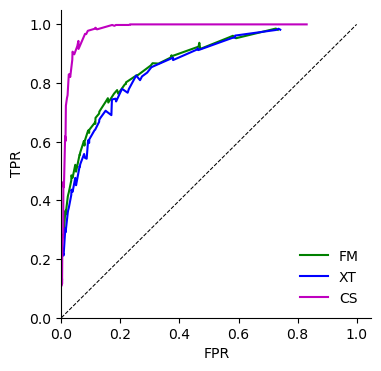

In [21]:
# plot ROC curves
fig, ax = plt.subplots(figsize=(4, 4))
ax.plot(fm_fpr, fm_tpr, 'g-', lw=1.5, label='FM')
ax.plot(xt_fpr, xt_tpr, 'b-', lw=1.5, label='XT')
ax.plot(cs_fpr, cs_tpr, 'm-', lw=1.5, label='CS')
ax.plot([0, 1], [0, 1], 'k--', lw=0.75, zorder=-1)
ax.legend(frameon=False)
for d in ['top', 'right']:
    ax.spines[d].set_visible(False)
ax.set_xlabel('FPR')
ax.set_ylabel('TPR')
ax.set_xlim([0, 1.05])
ax.set_ylim([0, 1.05])
plt.show()
plt.close()


In [74]:
np.random.seed(420)

# compute similarities between different combined spectra
nist_between_sims = [] 
qry_sel1 = 'SELECT name, adduct, pre_mz, msms_mz, msms_i FROM msms'
qry_sel2 = 'SELECT msms_mz, msms_i FROM msms WHERE NOT (name==? AND adduct==?) AND pre_mz>=? AND pre_mz<=?'
i = 0
for name, adduct, pre_mz, msms_mz, msms_i in cur_nist_c.execute(qry_sel1).fetchall():
    if np.random.random() >= 1 / 37:  # sample around 1000
        # skip this iteration of the loop
        continue
    spectrum = [np.frombuffer(msms_mz), np.frombuffer(msms_i)]
    mz_min, mz_max = pre_mz - 0.1, pre_mz + 0.1 
    for msms_mz2, msms_i2 in cur_nist_c.execute(qry_sel2, (name, adduct, mz_min, mz_max)).fetchall():
        spectrum2 = [np.frombuffer(msms_mz2), np.frombuffer(msms_i2)]
        nist_between_sims.append(spec_entropy_similarity(spectrum, spectrum2))
    i += 1
    if i % 100 == 0:
        print('completed', i, 'outer loops')

# fetch mean similarity within combined spectra
nist_within_sims = [_[0] for _ in cur_nist_c.execute("SELECT mean_spec_sim FROM msms").fetchall()]

print('# of between comparisons:', len(nist_between_sims))


completed 100 outer loops
completed 200 outer loops
completed 300 outer loops
completed 400 outer loops
completed 500 outer loops
completed 600 outer loops
completed 700 outer loops
completed 800 outer loops
completed 900 outer loops
completed 1000 outer loops
# of between comparisons: 73900


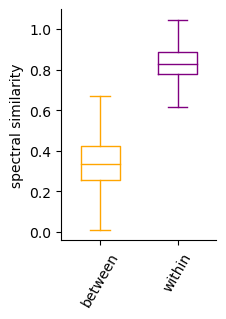

In [76]:
fig, ax = plt.subplots(figsize=(2, 3))
props = lambda c: {k: {'color': c, 'markeredgecolor': c} for k in ['boxprops', 'medianprops', 'flierprops', 'whiskerprops', 'capprops']}
w = 0.5
ax.boxplot(nist_between_sims, widths=w, positions=[1], showfliers=False, **props('orange'))
ax.boxplot(nist_within_sims, widths=w, positions=[2], showfliers=False, **props('purple'))
ax.set_ylabel('spectral similarity')
ax.set_xticks([1, 2])
#ax.set_ylim([0, 1])
ax.set_xticklabels(['between', 'within'], rotation=60)
for d in ['top', 'right']:
    ax.spines[d].set_visible(False)
#plt.tight_layout()
plt.show()
plt.close()


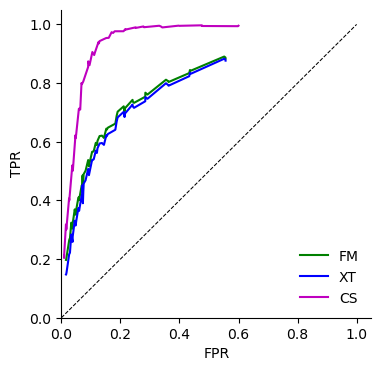

In [29]:
# compile the full match results (threshold, FPR, TPR)
full_match_results = []
for jsonf in ['MoNA_full_match_test.json']:
    with open(jsonf, 'r') as jf:
        data = json.load(jf)
    for rep in data:
        for threshold in rep:
            d = rep[threshold]
            full_match_results.append([float(threshold), d['fp'] / (d['fp'] + d['tn']), d['tp'] / (d['tp'] + d['fn'])])
            
fm_thr, fm_fpr, fm_tpr = np.array(sorted(full_match_results, key=lambda x: x[1])).T


# compile the exclude target results (threshold, FPR, TPR)
exclude_target_results = []
for jsonf in ['MoNA_exclude_target_match_test.json']:
    with open(jsonf, 'r') as jf:
        data = json.load(jf)
    for rep in data:
        for threshold in rep:
            d = rep[threshold]
            exclude_target_results.append([float(threshold), d['fp'] / (d['fp'] + d['tn']), d['tp'] / (d['tp'] + d['fn'])])
            
xt_thr, xt_fpr, xt_tpr = np.array(sorted(exclude_target_results, key=lambda x: x[1])).T

# compile the combined spectra results (threshold, FPR, TPR)
combined_spectra_results = []
for jsonf in ['MoNA_combined_spectra_match_test.json']:
    with open(jsonf, 'r') as jf:
        data = json.load(jf)
    for rep in data:
        for threshold in rep:
            d = rep[threshold]
            combined_spectra_results.append([float(threshold), d['fp'] / (d['fp'] + d['tn']), d['tp'] / (d['tp'] + d['fn'])])
            
cs_thr, cs_fpr, cs_tpr = np.array(sorted(combined_spectra_results, key=lambda x: x[1])).T

# plot ROC curves
fig, ax = plt.subplots(figsize=(4, 4))
ax.plot(fm_fpr, fm_tpr, 'g-', lw=1.5, label='FM')
ax.plot(xt_fpr, xt_tpr, 'b-', lw=1.5, label='XT')
ax.plot(cs_fpr, cs_tpr, 'm-', lw=1.5, label='CS')
ax.plot([0, 1], [0, 1], 'k--', lw=0.75, zorder=-1)
ax.legend(frameon=False)
for d in ['top', 'right']:
    ax.spines[d].set_visible(False)
ax.set_xlabel('FPR')
ax.set_ylabel('TPR')
ax.set_xlim([0, 1.05])
ax.set_ylim([0, 1.05])
plt.show()
plt.close()


In [78]:
np.random.seed(420)

# compute similarities between different combined spectra
mona_between_sims = [] 
qry_sel1 = 'SELECT name, adduct, pre_mz, msms_mz, msms_i FROM msms'
qry_sel2 = 'SELECT msms_mz, msms_i FROM msms WHERE NOT (name==? AND adduct==?) AND pre_mz>=? AND pre_mz<=?'
i = 0
for name, adduct, pre_mz, msms_mz, msms_i in cur_mona_c.execute(qry_sel1).fetchall():
    if np.random.random() >= 1.1:  # sample around 1000
        # skip this iteration of the loop
        continue
    spectrum = [np.frombuffer(msms_mz), np.frombuffer(msms_i)]
    mz_min, mz_max = pre_mz - 0.1, pre_mz + 0.1 
    for msms_mz2, msms_i2 in cur_mona_c.execute(qry_sel2, (name, adduct, mz_min, mz_max)).fetchall():
        spectrum2 = [np.frombuffer(msms_mz2), np.frombuffer(msms_i2)]
        mona_between_sims.append(spec_entropy_similarity(spectrum, spectrum2))
    i += 1
    if i % 100 == 0:
        print('completed', i, 'outer loops')

# fetch mean similarity within combined spectra
mona_within_sims = [_[0] for _ in cur_mona_c.execute("SELECT mean_spec_sim FROM msms").fetchall()]

print('# of between comparisons:', len(mona_between_sims))


completed 100 outer loops
completed 200 outer loops
completed 300 outer loops
completed 400 outer loops
completed 500 outer loops
completed 600 outer loops
completed 700 outer loops
completed 800 outer loops
completed 900 outer loops
completed 1000 outer loops
completed 1100 outer loops
completed 1200 outer loops
completed 1300 outer loops
completed 1400 outer loops
completed 1500 outer loops
completed 1600 outer loops
completed 1700 outer loops
completed 1800 outer loops
completed 1900 outer loops
completed 2000 outer loops
completed 2100 outer loops
completed 2200 outer loops
completed 2300 outer loops
completed 2400 outer loops
completed 2500 outer loops
completed 2600 outer loops
completed 2700 outer loops
completed 2800 outer loops
completed 2900 outer loops
completed 3000 outer loops
completed 3100 outer loops
completed 3200 outer loops
completed 3300 outer loops
completed 3400 outer loops
completed 3500 outer loops
completed 3600 outer loops
completed 3700 outer loops
completed 

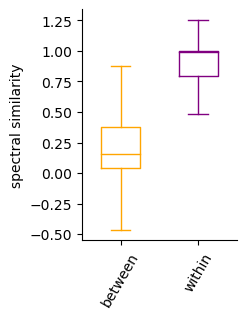

In [79]:
fig, ax = plt.subplots(figsize=(2, 3))
props = lambda c: {k: {'color': c, 'markeredgecolor': c} for k in ['boxprops', 'medianprops', 'flierprops', 'whiskerprops', 'capprops']}
w = 0.5
ax.boxplot(mona_between_sims, widths=w, positions=[1], showfliers=False, **props('orange'))
ax.boxplot(mona_within_sims, widths=w, positions=[2], showfliers=False, **props('purple'))
ax.set_ylabel('spectral similarity')
ax.set_xticks([1, 2])
#ax.set_ylim([0, 1])
ax.set_xticklabels(['between', 'within'], rotation=60)
for d in ['top', 'right']:
    ax.spines[d].set_visible(False)
#plt.tight_layout()
plt.show()
plt.close()
